In [130]:
#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [134]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

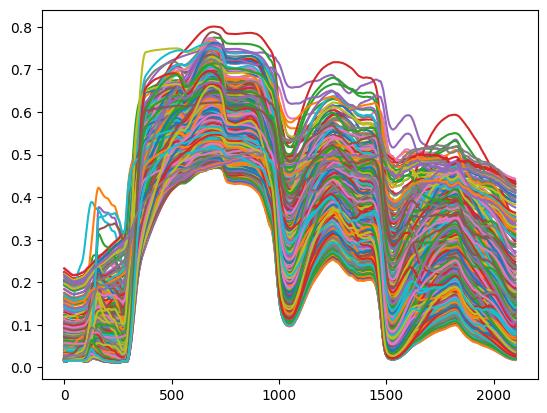

In [135]:
krange=1000
n=1.28
chloro= rand(krange)*80
caroten=rand(krange)*10
brown=rand(krange)*1
EWT=rand(krange)*0.009
LMA=rand(krange)*0.009
LAI=rand(krange)*10
hot_spot=0.1+rand(krange)*0.3
tts = 0 # solar zenith angle (in degrees)
tto = 10 # sensor zenith angle (in degrees)
psi = 30 # Azimuth angle - difference between sun and sensor (in degrees)
typelidf=1
lidfa = 0 #leaf angle distribution parameter a and b (Spherical)
lidfb=0
rsoil = 1 # soil reflectance 
psoil = 1 #soil reflectance at the red edge position 

#soilType=pyPro4SAIL.DEFAULT_SOIL
#sal=len(solar_zenith)
#rho=np.zeros((sal,krange,2101))
rho_out = np.zeros((krange,2101))
for i in range(krange):
    rho_out[i,:] = prosail.run_prosail(1.2,chloro[i],caroten[i],brown[i], EWT[i], LMA[i], LAI[i], lidfa,hot_spot[i],tts,tto,psi, typelidf=1, lidfb=0,
                                 factor='DHR', rsoil=1, psoil= 1)
plt.plot(rho_out.T);

In [67]:
#this function also transforms the hyperspectral data to sentinel data
def Prosail2S2(path2csv, spectra_input):
    #importing pandas
    import pandas as pd
    import numpy
    import numpy as np
    
    s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
    s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
    spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
    rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
    w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

    output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

    return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"


In [91]:
tr_rho_s = np.zeros((1000, 9))
for i in range(1000):
    tr_rho_s[i, :] = Prosail2S2(filepath,  rho_out[i,0:2101].T)[np.array((2,3,4,5,6,7,8,11,12))]
print(tr_rho_s.shape)

simulated = pd.DataFrame(tr_rho_s, columns = ('BAND_2', 'BAND_3', 'BAND_4', 'BAND_5', 'BAND_6', 'BAND_7', 'BAND_8', 'BAND_11', 'BAND_12'))


(1000, 9)


In [92]:
simulated

,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_11,BAND_12
0,0.133780,0.062236,0.221604,0.416942,0.478581,0.513321,0.532703,0.329312,0.151557
1,0.049727,0.028603,0.112292,0.235196,0.306372,0.373644,0.414710,0.299520,0.128192
2,0.044676,0.024018,0.099668,0.223756,0.291552,0.352354,0.389209,0.244639,0.092126
3,0.027341,0.018034,0.054549,0.285640,0.416228,0.479102,0.515930,0.558390,0.455347
4,0.042153,0.030437,0.074597,0.326463,0.425496,0.449115,0.462340,0.376495,0.203662
...,...,...,...,...,...,...,...,...,...
995,0.018576,0.013117,0.036417,0.238009,0.375701,0.449767,0.494516,0.357591,0.179038
996,0.230052,0.272085,0.301838,0.346110,0.372656,0.396653,0.410785,0.497876,0.461905
997,0.023024,0.013608,0.048520,0.240872,0.363312,0.449904,0.503410,0.381381,0.206582
998,0.036276,0.016027,0.075742,0.259846,0.350067,0.410194,0.446058,0.271498,0.111411


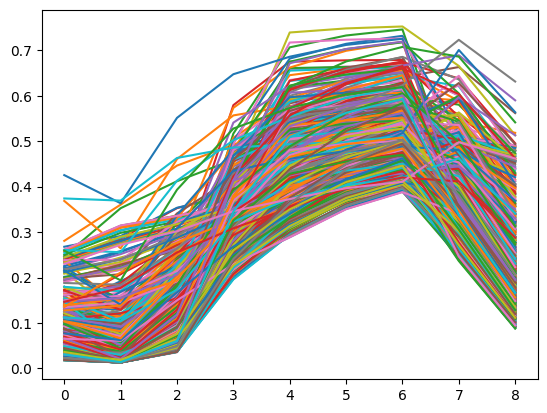

In [87]:
plt.plot(tr_rho_s.T);

# Dataframes to store values of extracted pixel

In [76]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [79]:
dataframe = r'C:\Users\BSibiya\Desktop\Sandberg Fynbos Reserve\dataset.xlsx'
df = pd.read_excel(dataframe)
#measured.head()

In [124]:
measured = df[['BAND_2', 'BAND_3', 'BAND_4', 'BAND_5','BAND_6', 'BAND_7', 'BAND_8', 'BAND_11','BAND_12']]
measured.head()
df_chloro = df[['CHLORO']]
df_chloro.head()

,CHLORO
0,21.22768
1,22.22008
2,23.79424
3,20.47040
4,20.31208


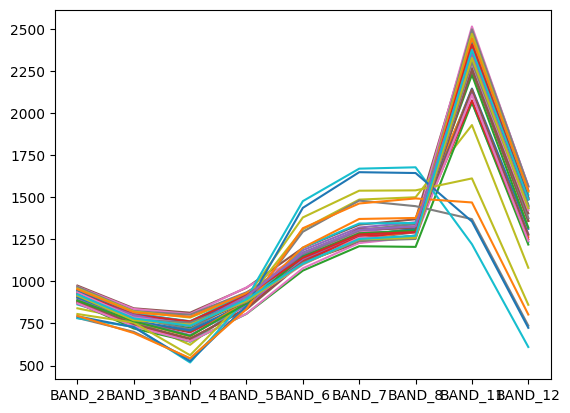

In [108]:
plt.plot(measured.T);

In [122]:
meas=np.array(measured)/np.mean(np.array(measured))*np.mean(np.array(simulated))
cab = []
for i in np.arange(40):
#     print(np.sum((np.array(simulated)-np.array(measured)[i,:])**2,axis=1))
    mses=np.sum((np.array(simulated)-meas[i,:])**2,axis=1)
    ind=np.argmin(mses)
    cab.append(chloro[i])
    #print(chloro[i])
    #print(ind,chloro[i], mses[ind])
chlorophyll = pd.DataFrame(cab, columns = ['chlor'])
chlorophyll.head()

,chlor
0,8.685156
1,15.682109
2,18.997347
3,63.666042
4,62.705556


In [96]:
new_data_simulated = simulated.T

In [97]:
new_data_measured = measured.T

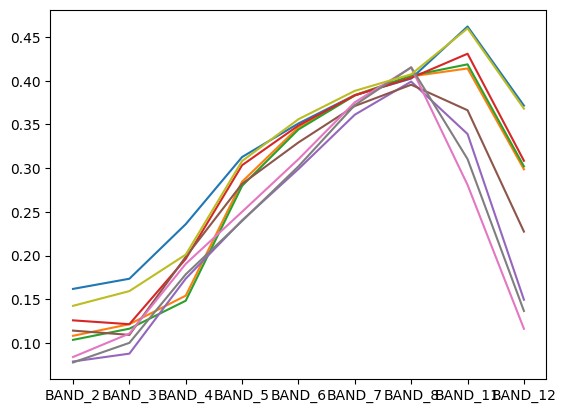

In [102]:
best_simulated = new_data_simulated[[626, 863, 114, 699, 715, 356, 869, 138, 770]]
plt.plot(best_simulated);

In [104]:
inner = pd.concat([new_data_measured, best_simulated], axis = 1)
inner

,0,1,2,3,4,5,6,7,8,9,...,39,626,863,114,699,715,356,869,138,770
BAND_2,934,948,921,948,964,975,969,968,958,946,...,923,0.161877,0.108227,0.103593,0.125905,0.078856,0.114184,0.083960,0.077726,0.142497
BAND_3,803,812,788,805,826,840,836,823,821,809,...,780,0.173507,0.121491,0.116364,0.121514,0.087827,0.109285,0.110809,0.100163,0.159376
BAND_4,760,758,724,759,789,814,806,802,785,763,...,736,0.235935,0.154160,0.148357,0.196215,0.173619,0.198618,0.190534,0.178544,0.201111
BAND_5,908,925,905,919,932,962,964,935,919,926,...,893,0.312740,0.284541,0.279732,0.303359,0.240262,0.282098,0.250121,0.239628,0.308149
BAND_6,1140,1160,1170,1145,1160,1199,1159,1123,1148,1135,...,1105,0.351113,0.346778,0.344249,0.348809,0.298988,0.329418,0.310262,0.302058,0.355972
BAND_7,1276,1291,1305,1279,1297,1337,1307,1250,1282,1278,...,1252,0.383542,0.383568,0.383141,0.383250,0.361155,0.371110,0.375391,0.372129,0.388417
BAND_8,1309,1341,1337,1297,1326,1369,1329,1292,1294,1307,...,1271,0.402476,0.404942,0.405794,0.403224,0.399015,0.395413,0.415111,0.415376,0.407304
BAND_11,2411,2405,2351,2428,2501,2486,2515,2498,2471,2435,...,2377,0.462031,0.414002,0.418721,0.430863,0.339049,0.366214,0.280858,0.310374,0.459869
BAND_12,1486,1500,1433,1491,1568,1542,1563,1564,1531,1515,...,1488,0.371484,0.298674,0.302033,0.308453,0.149512,0.227415,0.116291,0.136633,0.368063


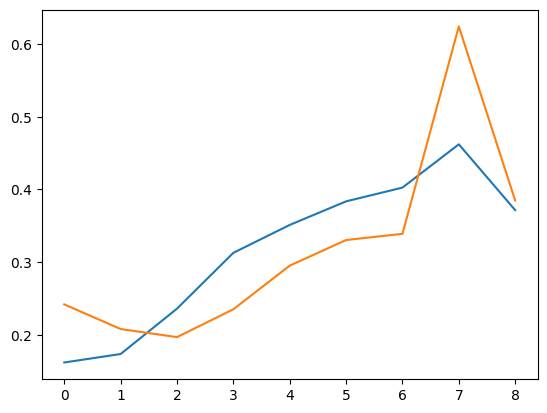

In [106]:
plt.plot(np.array(inner)[:,-9]);
plt.plot(np.array(inner)[:,0]/np.mean(np.array(inner)[:,0])*np.mean(np.array(inner)[:,-9]));

In [110]:
chloro[ind]

22.90655463770281

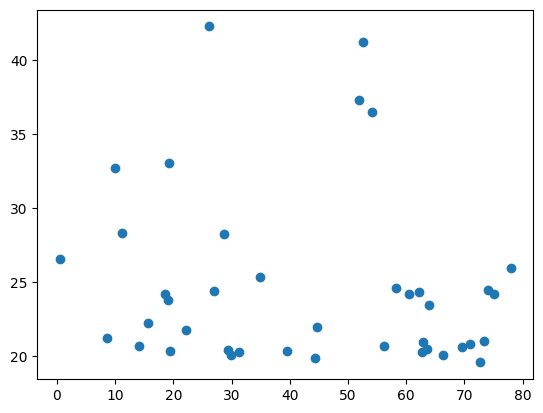

In [125]:
plt.scatter(chlorophyll, df_chloro);

In [126]:
chlorop = pd.concat([chlorophyll, df_chloro], axis = 1)

In [129]:
chlorop.to_excel("/Users/BSibiya/Desktop/study_area/output.xlsx")  